Alexander W. Criswell 10/16/25

Testing the new plotting functions, etc..

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import cupy as xp
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoLocator
from matplotlib.pyplot import cycler
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from matplotlib.collections import LineCollection
import matplotlib.cm
from matplotlib import patches
# import jax.numpy as jnp
# import jax; jax.config.update("jax_enable_x64", True)
from corner import corner, overplot_lines
import legwork as lw
import astropy.units as u
from tqdm import tqdm
from math import factorial

In [3]:
from eryn.ensemble import EnsembleSampler
from eryn.state import State
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.utils import TransformContainer
from eryn.moves import GaussianMove, StretchMove, CombineMove, DistributionGenerate, MTDistGenMove, Move
from eryn.utils.utility import groups_from_inds
from multiprocessing import Pool

In [4]:
np.random.seed(42)

In [5]:
xp.cuda.is_available()

True

In [6]:
## set environment variables
import os
os.environ['PELARGIR_GPU'] = '1'
os.environ['SCIPY_ARRAY_API'] = '1'
os.environ['PELARGIR_ERYN'] = '1'

In [7]:
if os.environ['PELARGIR_GPU']:
    print('GPU enabled.')

GPU enabled.


In [8]:
import sys
prop_path = '/home/awc/Documents/LISA/projects/lisa_population_inference/pelargir-gb/pelargir/'
sys.path.insert(1, prop_path)
from models import PopModel
from inference import GalacticBinaryPrior, PopulationHyperPrior
from utils import get_amp_freq, lisa_noise_psd, set_style
from plotting import plot_corners, plot_current_spectra, plot_distance_recovery, plot_model_chains, plot_model_loglikes
from moves import make_PriorMove, PoissonMove
import distributions as st

GPU requested and available; running Pelargir population inference on GPU.
GPU requested and available; running Pelargir population inference on GPU.
GPU requested and available; running Pelargir population inference on GPU.
GPU requested and available; running Pelargir population inference on GPU.
GPU requested and available; running Pelargir population inference on GPU.


In [9]:
set_style()

In [10]:
test_rng = xp.random.default_rng(170817)

In [11]:
test_prior = GalacticBinaryPrior(test_rng)

In [12]:
pop_theta = {'m_mu':xp.array([0.6]),'m_sigma':xp.array([0.15]),
             # 'd_mu':xp.array([30]),'d_sigma':xp.array([10]),
             'd_gamma_a':xp.array([4]),'d_gamma_b':xp.array([4]),
             'a_alpha':xp.array([1/2])}
test_prior.condition(pop_theta)

In [13]:
samps = test_prior.sample_conditional(int(1e7))

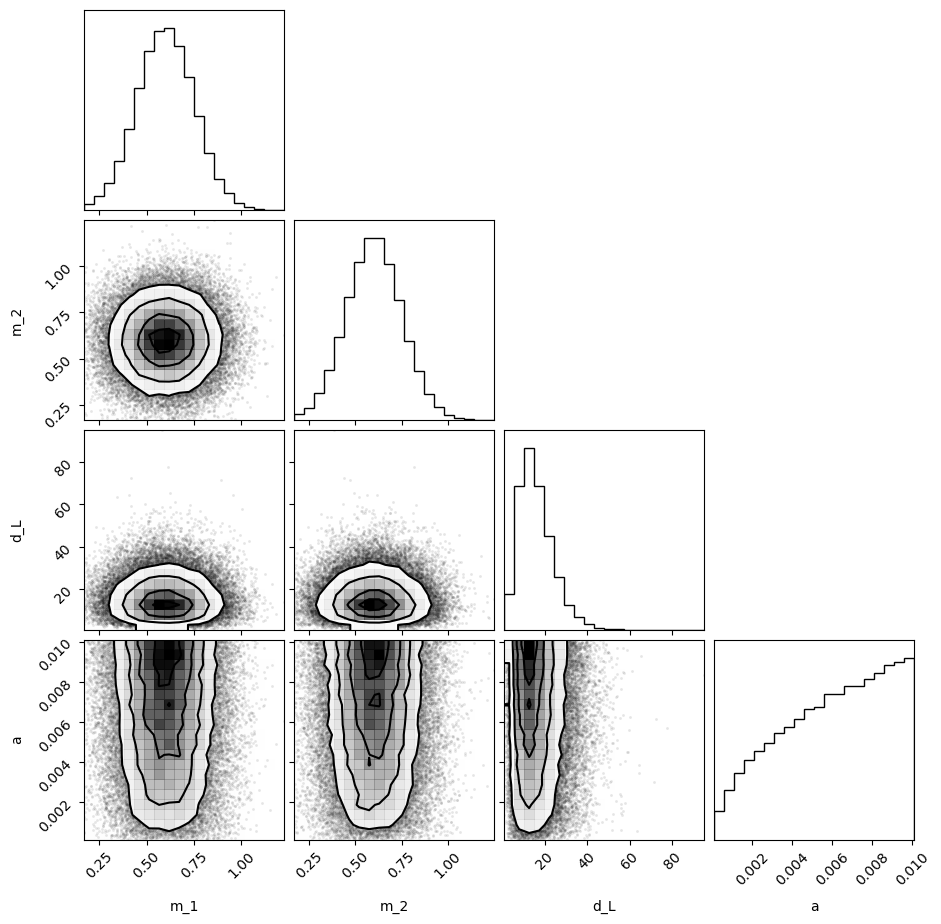

In [14]:
plt.close()
fig = corner(samps[:,::200].get().T,labels=list(test_prior.conditional_dict.keys()))
plt.show()

In [15]:
amps, fgws = get_amp_freq(samps)

In [16]:
test_hprior = PopulationHyperPrior(test_rng)

In [17]:
test_bin_width = 1e-5
test_fbins = xp.arange(1e-4,2e-3,test_bin_width)
test_popmodel = PopModel(1e7,test_rng,hyperprior=test_hprior,Nsamp=1,thresh_compute_frac=1.0,fbins=test_fbins)

In [18]:
test_f, test_fg, N_res = test_popmodel.run_model(pop_theta)

To compare to the initial population draw, we need to run the thresholder on it.

In [19]:
data_N_res, data_coarse_fg = test_popmodel.thresher.serial_array_sort(xp.array([fgws,amps]),
                                                                      test_popmodel.fbins,
                                                                      snr_thresh=test_popmodel.thresh_val,
                                                                      compute_frac=test_popmodel.tc_frac)
data_fg = test_popmodel.reweight_foreground(data_coarse_fg)[1:]

In [20]:
data_N_res

array(42)

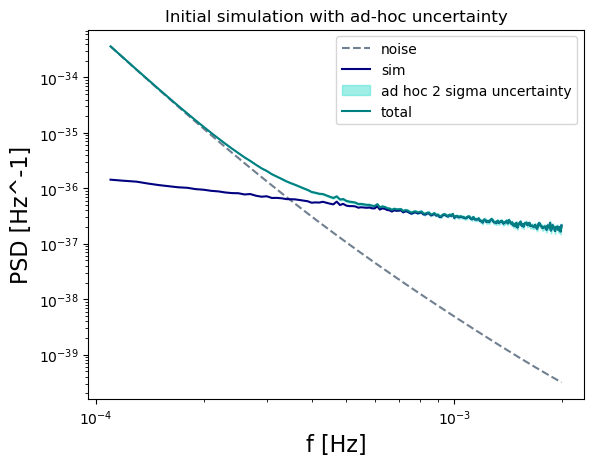

In [61]:
total_fs = test_f.get()
total_spec = data_fg.get() + lisa_noise_psd(test_f).get()
# errs = 0.05*total_spec
errs = 1e-38
plt.figure()
plt.loglog(total_fs,lisa_noise_psd(test_f).get(),c='slategrey',ls='--',label='noise')
plt.loglog(total_fs,data_fg.get(),c='navy',label='sim')
# plt.fill_between(total_fs,10**(np.log10(total_spec)-2*err),10**(np.log10(total_spec)+2*err),
#                  color='turquoise',alpha=0.5,label='ad hoc 2 sigma uncertainty')
plt.fill_between(total_fs,total_spec-2*errs,total_spec+2*errs,
                 color='turquoise',alpha=0.5,label='ad hoc 2 sigma uncertainty')
plt.loglog(total_fs,total_spec,label='total',c='teal')
plt.legend()
plt.xlabel('f [Hz]')
plt.ylabel('PSD [Hz^-1]')
plt.title('Initial simulation with ad-hoc uncertainty')
# plt.ylim(1e-40,1e-36)
plt.show()

In [62]:
## setup w.r.t. the data
datadict = {'fs':test_f,
            'fg':data_fg,
            'fg_sigma':xp.array(errs),
            'Nres':data_N_res,
            'noise':lisa_noise_psd(test_f)}

In [63]:
test_rng = xp.random.default_rng(42)

In [64]:
translation_dict = {0:'m_mu',
                    1:'m_sigma',
                    2:'d_gamma_a',
                    3:'d_gamma_b',
                    4:'a_alpha'}
## starting with the broader priors
eryn_hyperprior_dict = {0:st.uniform(test_rng,loc=0.5,scale=0.2,cast=True),
                        1:st.invgamma(test_rng,5,cast=True),
                        2:st.uniform(test_rng,loc=2.5,scale=3,cast=True), ## these are pretty arbitrary
                        3:st.uniform(test_rng,loc=2.5,scale=3,cast=True), ## these are pretty arbitrary
                        4:st.uniform(test_rng,0.25,0.75,cast=True)}
eryn_trans_dict = {translation_dict[key]:eryn_hyperprior_dict[key] for key in eryn_hyperprior_dict.keys()}

In [65]:
eryn_trans_dict

{'m_mu': <distributions.uniform at 0x770918291c10>,
 'm_sigma': <distributions.invgamma at 0x7708ca74eb40>,
 'd_gamma_a': <distributions.uniform at 0x7708ca792270>,
 'd_gamma_b': <distributions.uniform at 0x7709700a20f0>,
 'a_alpha': <distributions.uniform at 0x7709703d1e80>}

In [66]:
eryn_prior = ProbDistContainer(eryn_hyperprior_dict)

In [67]:
eryn_popmodel = PopModel(1e7,test_rng,hyperprior=eryn_trans_dict,fbins=test_fbins)

In [68]:
eryn_popmodel.construct_likelihood(datadict)

In [69]:
log_like_fn = eryn_popmodel.fg_N_ln_prob

In [70]:
ndim = len(eryn_popmodel.hyperprior.hyperprior_dict)
nwalkers = 10

In [71]:
## MH with prior draws as the proposal function
PriorMove = make_PriorMove(eryn_prior)
# PriorMove = DistributionGenerate({'model_0':eryn_prior})

We should now have fixed the issue causing these to be -inf, so we can drop the while statement.

In [72]:
# starting positions
# randomize throughout prior
coords = eryn_prior.rvs(size=(nwalkers,))

log_like=xp.empty(nwalkers)
for i in tqdm(range(nwalkers)):
    log_like[i] = log_like_fn(coords[i])

print("Log-likelihood:\n", log_like)

# check log_prior
log_prior = xp.asarray([eryn_prior.logpdf(coords[i]) for i in range(nwalkers)])
print("\nLog-prior:\n", log_prior)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.90it/s]

Log-likelihood:
 [-1.53985393e+03 -8.43496191e+04 -1.00637879e+07 -1.16827673e+06
 -5.95019550e+06 -2.92659898e+04 -5.40821342e+04 -8.30071157e+04
 -1.27710962e+05 -1.21391039e+05]

Log-prior:
 [0.86118009 1.25089694 1.22826266 1.51522869 0.56837611 1.44484385
 1.33217912 1.55505861 1.53629572 1.57200972]


Build an Eryn ensemble with the full move mixture:

In [73]:
ensemble = EnsembleSampler(nwalkers,
                           ndim,
                           log_like_fn,
                           eryn_prior,
                           moves=[(StretchMove(),0.45),(PriorMove,0.1),(PoissonMove(),0.45)],
                           track_moves=True,
                          )

Let's look at the starting position...

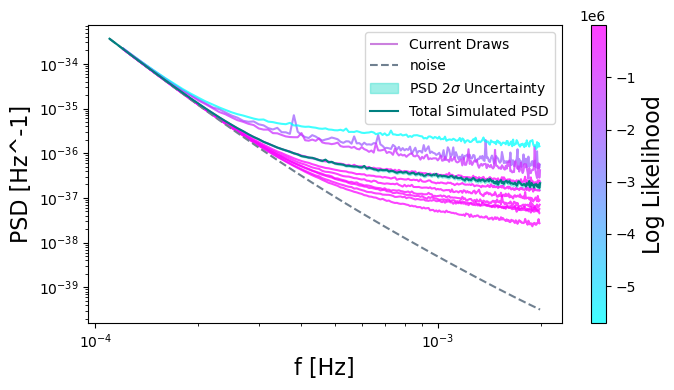

In [74]:
plot_current_spectra(coords,datadict,eryn_popmodel)

In [90]:
nsteps = 50
burn = None
thin_by = 1
out = ensemble.run_mcmc(coords, nsteps, burn=burn, progress=True, thin_by=thin_by)
# pool.close()
# pool.join()

  2%|████                                                                                                                                                                                                     | 1/50 [00:01<01:23,  1.71s/it]/home/awc/.local/share/mamba/envs/gwenv-1/lib/python3.12/site-packages/eryn/ensemble.py:1267: UserWarning: All points input for the Likelihood have a log prior of -inf.
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:35<00:00,  3.10s/it]


In [91]:
ensemble.acceptance_fraction

array([[0.43333333, 0.55      , 0.53333333, 0.6       , 0.6       ,
        0.51666667, 0.5       , 0.53333333, 0.61666667, 0.6       ]])

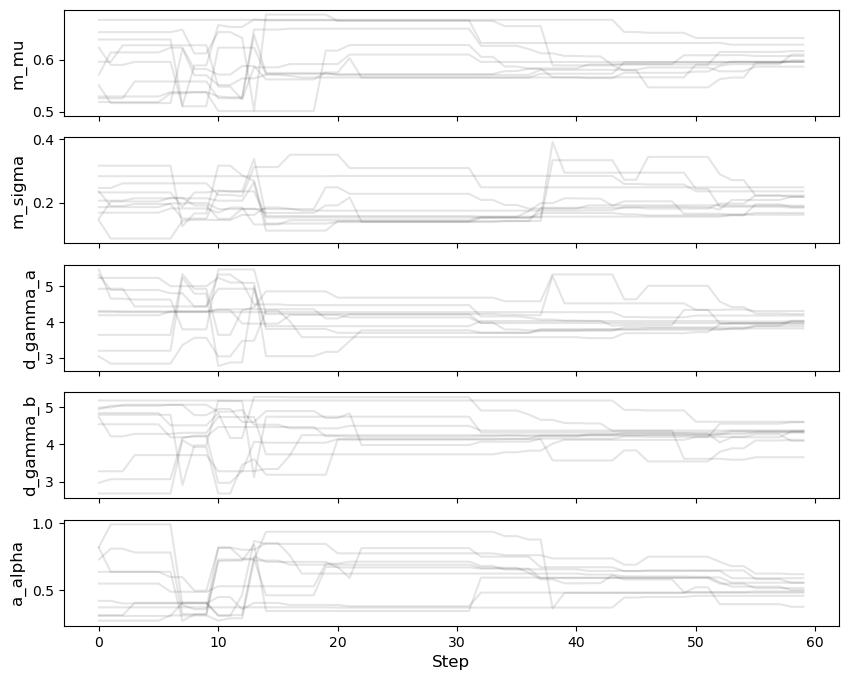

In [92]:
plot_model_chains(ensemble,names=eryn_popmodel.hpar_names)

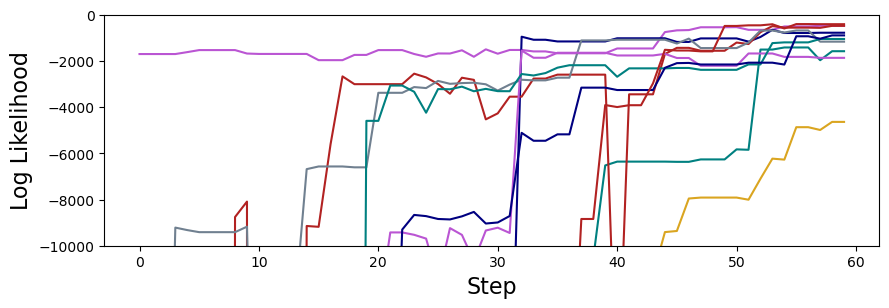

In [93]:
plot_model_loglikes(ensemble,names=eryn_popmodel.hpar_names,ylim=(-1e4,0))

Where are they now?

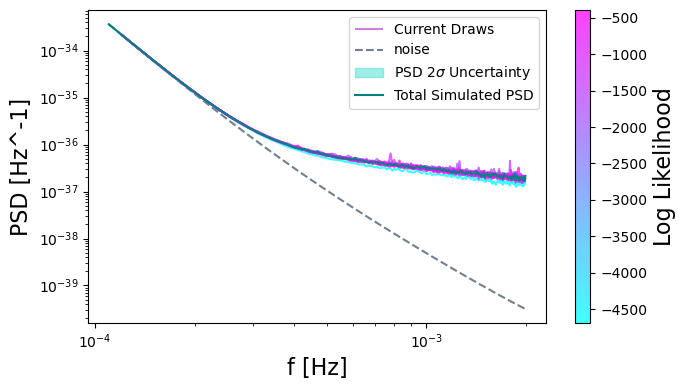

In [94]:
current_state = ensemble.get_chain()['model_0'][-1,...].reshape(10,5)
spec_dict = plot_current_spectra(current_state,datadict,eryn_popmodel,return_spectra=True)

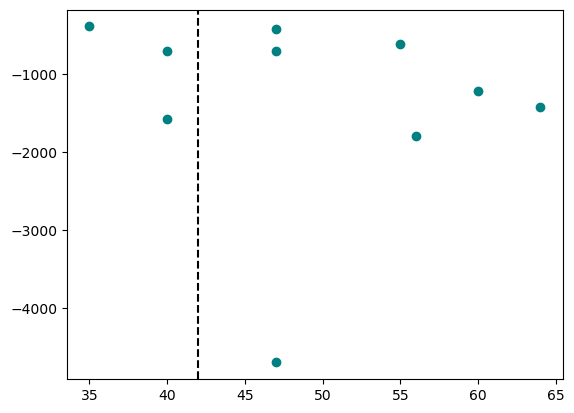

In [95]:
plt.figure()
plt.scatter(spec_dict['N_res'],spec_dict['loglike'],c='teal')
plt.axvline(datadict['Nres'].get(),c='k',ls='--')
plt.show()

In [96]:
injdict = pop_theta
truths = xp.asnumpy([injdict[key].get() for key in injdict.keys()]).flatten()

In [97]:
truths

array([0.6 , 0.15, 4.  , 4.  , 0.5 ])

In [98]:
samples = ensemble.get_chain()['model_0'].reshape(-1, ndim)

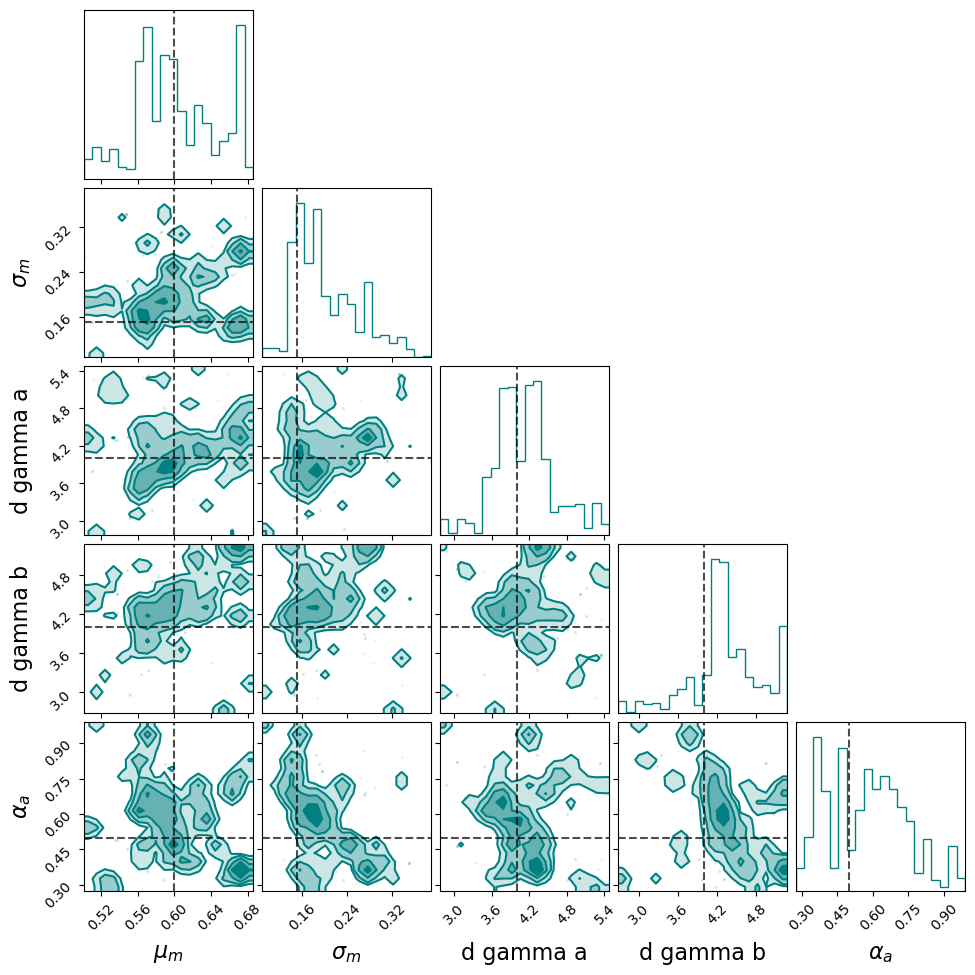

In [99]:
plot_corners(samples,parameters=[r'$\mu_m$',r'$\sigma_m$',r'd gamma a',r'd gamma b',r'$\alpha_a$'],
             Nbins=20,figsize=(10,10),truths=truths,density=False,plot_datapoints=True
             )